<a href="https://colab.research.google.com/github/darshitajain/CRC-RL-/blob/main/ViT_CIFAR10_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementation of the paper- "[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)"

#### Notebook created by- [Darshita Jain](https://www.linkedin.com/in/jain-darshita/)


---



#### **Before starting with the implementation a few points to note-**
* #### This notebook contains implementation of Vision transformer for CIFAR10 dataset. Please note that the original ViT base model is having 82M params which is huge for training on a comparatively small dataset like CIFAR 10.
* #### When I trained the CIFAR10 dataset directly using the same parameters as ViT base model, the model was highly overfitting on train dataset and loss values were becoming Nan. To reduce overfitting the three mains things that can be modified are:   

    1.   Reducing the model size (number of layers and number of neurons in each layer)
    2.   Increase dropout
    3.   Data augmentation.

* #### I started with reducing the parameters of the model by using the below hyperparameter setting- 
      config= {"img_size":"32",
              "patch_size":"4", 
              "batch_size":"512", 
              "mlp_size":"512", 
              "emb_dim":"512", 
              "lr":"0.0001", 
              "num_heads":"8", 
              "num_trans_layer":"6"}
#### as opposed to what is mentioned in table 1 and 3 (in below cells) of ViT paper. 

* #### Even after doing the above changes, the train and test loss were still Nan. Then I reduced the learning rate from 3e-3(mentioned in the paper) to 1e-4 and it started learning something. After training for few epochs the model started to overfit again as shown in the plot below.

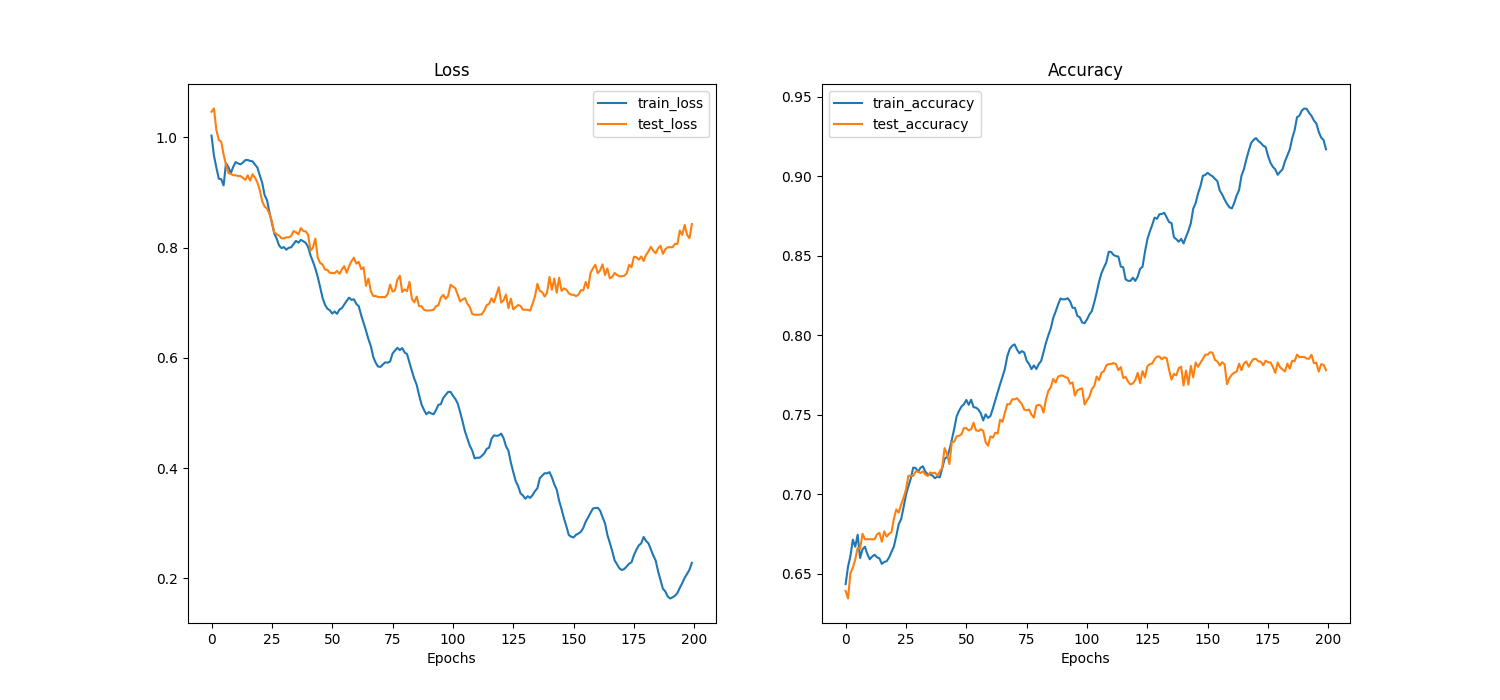

* #### To reduce overfitting, I increased the embedding dropout from 0.0 to 0.1 results for the same are shown below.

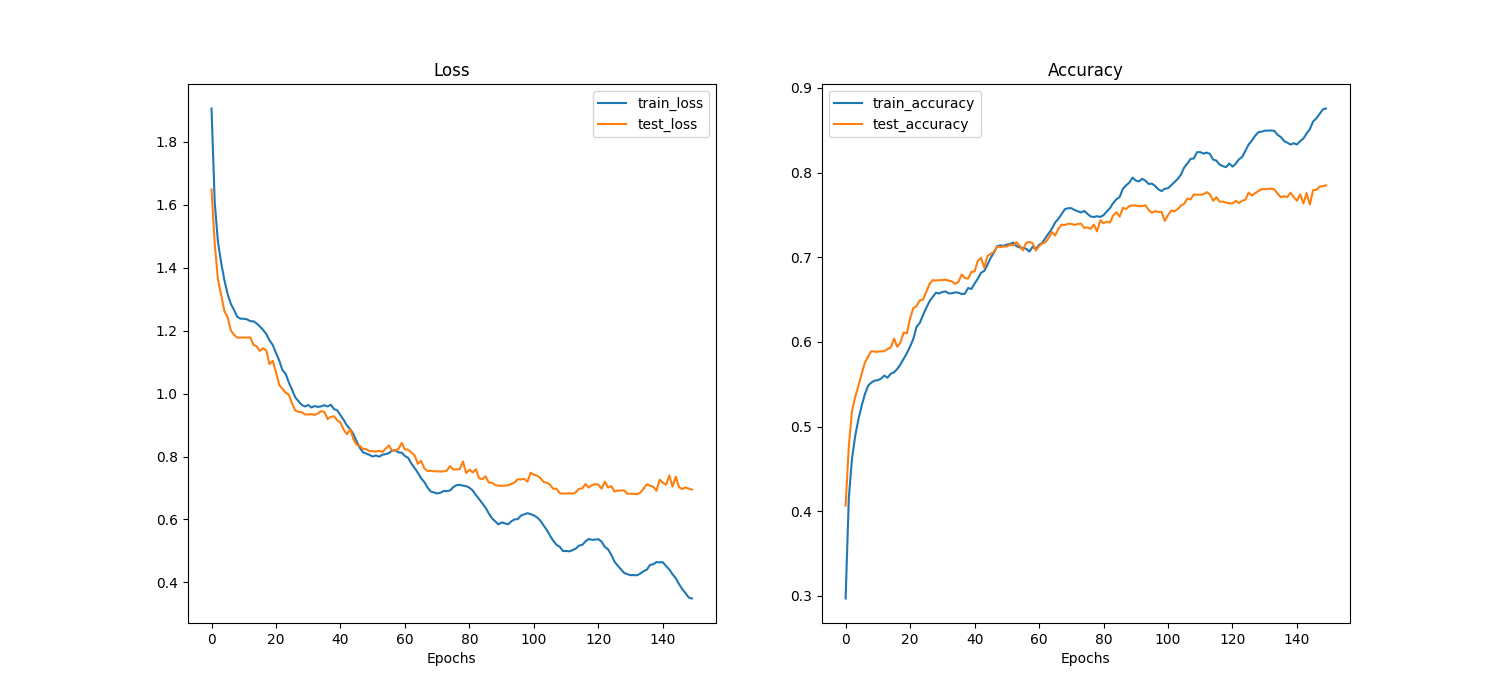

* #### The performance can be improved even more by increasing dropout, adding data augmentations, etc. For now this implementation is in a working state and can be extended for different datasets by doing appropriate hyperparameter modifications.

### **Weights and Bias logging [report](https://wandb.ai/darshita-jain/ViT_CIFAR10/reports/Train-and-test-plots--Vmlldzo0Mjc4NzAy)**


### **Key learning from this implementation exercise-**
1. #### A working understanding of how to downscale large models for smaller dataset. 
2. #### Effect of different hyperparameters on reducing overfitting.

#### **References-**
*  https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
*  https://github.com/IgorSusmelj/pytorch-styleguide#recommended-code-structure-for-training-your-model
*  https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import matplotlib.pyplot as plt
import numpy as np

try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    from torchinfo import summary
    from torch import nn
    from torchvision import transforms
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118
[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# setting the hyper parameters
import argparse

parser = argparse.ArgumentParser(description="Hyperparameters for training ViT on CIFAR-10")
parser.add_argument('-f')
parser.add_argument("--img_size", default="32", type=int)
parser.add_argument("--patch_size", default="4", type=int)
parser.add_argument("--batch_size", default="512", type=int)
parser.add_argument("--mlp_size", default="512", type=int)
parser.add_argument("--emb_dim", default="512", type=int)
parser.add_argument("--lr", default="1e-4", type=float)
parser.add_argument("--num_heads", default="8", type=int)
parser.add_argument("--num_trans_layer", default="6", type=int)
parser.add_argument("--n_epochs", default="10", type=int)
parser.add_argument("--wandb_flag", default=True, type=bool)

args = parser.parse_args()

print(args.__str__())

Namespace(f='/root/.local/share/jupyter/runtime/kernel-1261cfe6-fc3a-41e9-a1f3-a1ffb4684355.json', img_size=32, patch_size=4, batch_size=512, mlp_size=512, emb_dim=512, lr=0.0001, num_heads=8, num_trans_layer=6, n_epochs=10, wandb_flag=True)


### Utility functions

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from pathlib import Path
import requests 

def set_seeds(seed: int=24):
  """Setting seed for code reproducibility.
  Args: 
    seed(int, optional): Random seed value. Defaults to 24.
  """
  # Set the seed for general torch operations
  torch.manual_seed(seed)
  # Set the seed for CUDA torch operations
  torch.cuda.manual_seed(seed)


# Plot loss curves of a model
def plot_loss_curves(results):
  """Plots training curves of a result directory.
  
  Args:
    results (dict): dictionary containing list of values, e.g.
      {"train_loss": [...],
       "train_acc": [...],
       "test_loss": [...],
       "test_acc": [...]}
  """

  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


# predictions.py

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (args.img_size, args.img_size),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Downloading and exploring the dataset

In [ ]:
# Using CIFAR-10 dataset from torchvision

from torchvision.transforms import ToTensor
from torchvision import datasets
from torchvision import transforms

IMG_SIZE = args.img_size #224 #Mentioned in Table 3 of ViT paper

# Create transform pipeline manually as per the paper
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform_train,
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


Shape of input image: torch.Size([3, 32, 32])
tensor([[[ 0.1879,  0.1297,  0.0910,  ..., -2.4291, -2.4291, -2.4291],
         [-0.1223, -0.0835,  0.0328,  ..., -2.4291, -2.4291, -2.4291],
         [-0.3549, -0.1029,  0.2073,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-0.5892, -0.6482, -0.6286,  ..., -2.4183, -2.4183, -2.4183],
         [-0.8646, -0.8646, -0.7662,  ..., -2.4183, -2.4183, -2.4183],
         [-1.0809, -0.8449, -0.5106,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-1.2264, -1.2654, -1.2459,  ..., -2.2214, -2.2214, -2.2214],

Text(0.5, 1.0, 'frog')

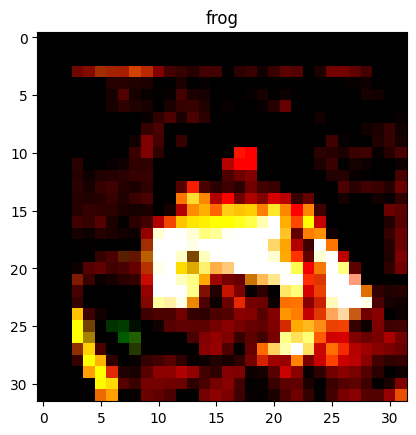

In [ ]:
# See first training sample
image, label = train_data[0]
print(f"Shape of input image: {image.shape}")
print(image, label)
print(f"Manually created transform for the downloaded dataset: {manual_transforms}")
# Printing the class names
class_names = train_data.classes
print(f"List of class names: {class_names}")

# Visualizing our data
image, label  = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze().permute(1,2,0).numpy())
plt.title(class_names[label])

#### Create DataLoader for CIFAR-10 dataset



In [ ]:
# Create Dataloader

from torch.utils.data import DataLoader

BATCH_SIZE = args.batch_size

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=4)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f32ec99bc70>, <torch.utils.data.dataloader.DataLoader object at 0x7f32ecb0c940>)
Length of train dataloader: 98 batches of 512
Length of test dataloader: 100 batches of 512


(torch.Size([512, 3, 32, 32]), torch.Size([512]))

### Replicating the ViT paper. What's ViT made of? 



1.Figure 1- This gives an overview of the model architecture of Vit.

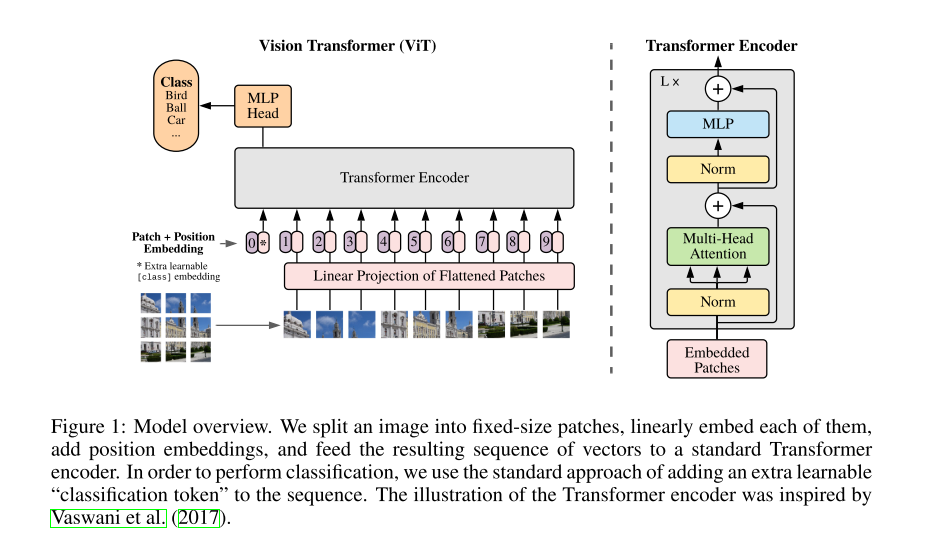


  ViT architecture comprises of different modules-



*   Patch + Positional embeddings
*   Linear projection of flattened patches
*   Layer Norm
*   Multi-Head Attention
*   MLP
*   Transformer Encoder
*   MLP head





2.Mathematical equations.
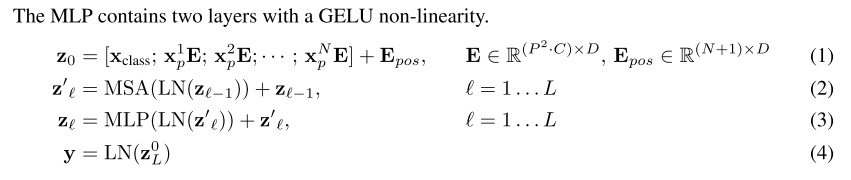

3.Table 1- Hyperparameter settings for different ViT model variants

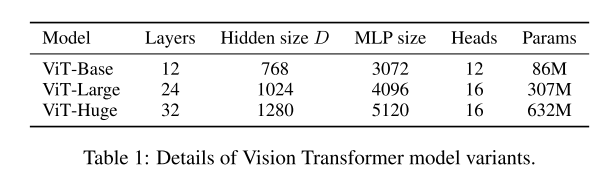

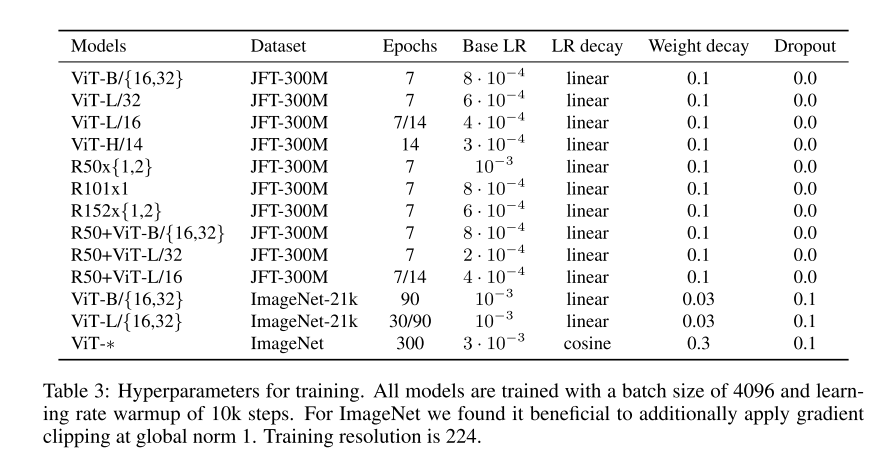







### Calculating patch embedding input and output shapes by hand

In [ ]:
# create example values

height = args.img_size 
width = args.img_size
color_channels = 3
patch_size = args.patch_size 

# Calculate N (number of patches)
num_patches = int((height * width) / (patch_size**2))
print(f"Number of patches (N) with H = {height}, W = {width} and patch size = {patch_size} = {num_patches}")

Number of patches (N) with H = 32, W = 32 and patch size = 4 = 64


#### Input- Image of dimension H x W x C
#### Output- Sequence of flattened 2D patches with size N x ($P^2$.C). This flattened output will be passed as input to the transformer encoder. 


In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (32, 32, 3)
Output shape (single 2D image flattened into patches): (64, 48)


### Creating images patches with torch.nn.Conv2d()

When the kernel_size and stride are set equal to patch_size then we can get a layer that splits our image into patches and creates a learnable embedding of each patch.

Input: The image dim is H x W x C.
(224, 224, 3) in case of ViT base model

Output: The image is converted into a sequence of flattened 2D patches with size N x ($P^2$.C)
(196, 768) -> (number of patches, embedding dimension)

In [ ]:
from torch import nn

patch_size = args.patch_size
conv2d = nn.Conv2d(in_channels=3,
                   out_channels= args.emb_dim, #512, #768, # Hidden dim D from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

out_conv = conv2d(image.unsqueeze(0))
print(f"{out_conv.shape} -> [batch_size, emb_dim, feature_map_height, feature_map_width]")

torch.Size([1, 512, 8, 8]) -> [batch_size, emb_dim, feature_map_height, feature_map_width]


Showing random convolutional feature maps from indexes: [216, 288, 415, 136, 437]


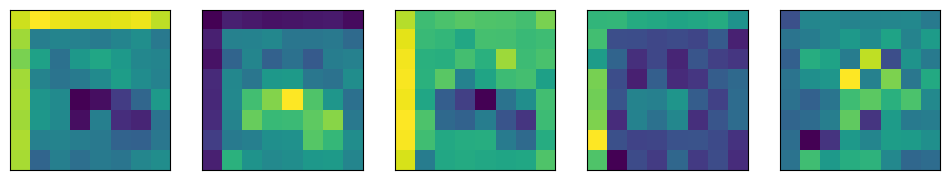

In [ ]:
# visualize random feature maps of out_conv

import random 
random_idx = random.sample(range(0, args.emb_dim), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_idx}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_idx):
  random_map = out_conv[:, idx, :, :]
  axs[i].imshow(random_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



### Flattening the patch embedding with torch.nn.Flatten()
Desired output: (196, 768) -> (number of patches, embedding dimension) -> N x ($P^2$.C)



---
**As stated in section 3.1 of the ViT paper-**
As a special case, the patches can have spatial size 1×1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension


In [ ]:
# current shape
print(f"Current tensor shape: {out_conv.shape} -> [batch_size, emb_dim, feature_ma_height, feature_map_width]")

Current tensor shape: torch.Size([1, 512, 8, 8]) -> [batch_size, emb_dim, feature_ma_height, feature_map_width]


In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, end_dim=3) # This will flatten the feature map height and feature map width

### Testing the above conv and flatten layer for a single image to check if the output dimensions are as required. (196, 768) -> N x ($P^2$.C)


Original image shape: torch.Size([3, 32, 32])
Image feature map shape: torch.Size([1, 512, 8, 8])
Flattened image feature map shape: torch.Size([1, 512, 64])


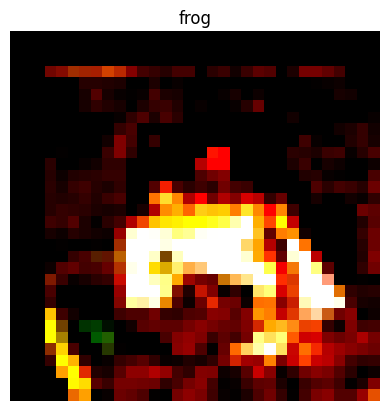

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
out_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {out_conv.shape}")

# 3. Flatten the feature maps
out_conv_flattened = flatten(out_conv)
print(f"Flattened image feature map shape: {out_conv_flattened.shape}")

Desired output: (196, 768) -> Nx($P^2$.C)

Current shape: (1, 768, 196)

Desired output dimension can be achieved by reordering the dimensions.

In [ ]:
out_conv_flattened_reshaped = out_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {out_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")


Patch embedding sequence shape: torch.Size([1, 64, 512]) -> [batch_size, num_patches, embedding_size]


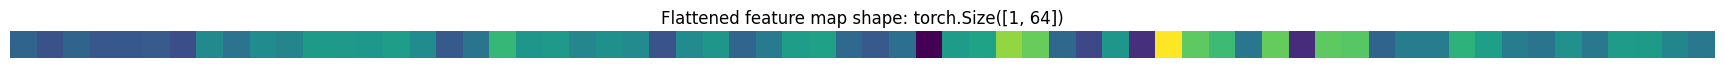

In [ ]:
# Visualizing a flattened feature map which is the output of patching embedding layer and input to the remaining modules of ViT

flattened_feature_map = out_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {flattened_feature_map.shape}")
plt.axis(False);

**Note:** The original Transformer architecture was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why the input to the ViT architecture is processed in this way. We are essentially taking a 2D image and formatting it so it appears as a 1D sequence of text.


### Creating a class for the patch embedding layer by combining conv2d and flatten layers.



In [ ]:
class PatchEmbedding(nn.Module):
  """Converts an input image into a sequence of learnable embedding vector.

  Args:
    in_channels (int): Number of color channels for the input image.
    patch_size (int): Input image is divided into smaller patches of the given size.
    embedding_dim (int): Size of embedding to turn image into.
  """
  def __init__(self,
               in_channels:int=3,
               patch_size:int=args.patch_size,
               embedding_dim:int=args.emb_dim):
    super().__init__()

    # Layer to turn image into patches
    self.generate_patches = nn.Conv2d(in_channels=in_channels,
                                      out_channels=embedding_dim,
                                      kernel_size=patch_size,
                                      stride=patch_size,
                                      padding=0)
    
    # Layer to flatten the patches into a single dimension
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
    
    # Define the forward method
  def forward(self, x):
    # check if the input size is divisible by patch size.
    img_res = x.shape[-1]
    assert img_res % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {img_res}, patch size: {patch_size}"
    x_patched = self.generate_patches(x)
    x_flattened = self.flatten(x_patched)
    # Make sure the output shape has the right order of dimensions i.e. [batch_size, P^2.C, N] -> [batch_size, N, P^2.C]
    return x_flattened.permute(0, 2, 1)
    

In [ ]:
# Checking the above class on a single image

set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size= args.patch_size,
                          embedding_dim=args.emb_dim)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 32, 32])
Output patch embedding shape: torch.Size([1, 64, 512])


#### Generating summary of the patch embedding layer


In [ ]:
random_input_img = (1, 3, args.img_size, args.img_size)
summary(PatchEmbedding(),
        input_size=random_input_img,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 32, 32]       [1, 64, 512]         --                   True
├─Conv2d (generate_patches)              [1, 3, 32, 32]       [1, 512, 8, 8]       25,088               True
├─Flatten (flatten)                      [1, 512, 8, 8]       [1, 512, 64]         --                   --
Total params: 25,088
Trainable params: 25,088
Non-trainable params: 0
Total mult-adds (M): 1.61
Input size (MB): 0.01
Forward/backward pass size (MB): 0.26
Params size (MB): 0.10
Estimated Total Size (MB): 0.37

### Creating the class token embedding
**Section 3.1 ViT paper** 
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches ($z_0^0 = x_{class}$), whose state at the output of the Transformer encoder ($z_L^0$) serves as the image representation y
 (Eq. 4).

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.8934,  0.1693, -0.9578, -0.4963, -0.0796, -0.5482, -0.4894,
          -0.3760, -0.0372,  1.9336]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 512]) -> [batch_size, number_of_tokens, embedding_dimension]
tensor([[[ 0.8934,  0.1693, -0.9578,  ..., -0.1186, -1.0414,  0.2244],
         [-0.7976,  0.2683, -1.7487,  ...,  0.4649, -0.9461,  0.4137],
         [-1.4757, -0.1479, -2.0525,  ...,  0.1146, -1.1244,  0.2707],
         ...,
         [-0.6109, -0.4811, -0.0272,  ..., -0.0668,  0.2469, -0.2251],
         [-0.6080, -0.6885,  0.0217,  ...,  0.1810,  0.3157, -0.2528],
         [-0.5641, -0.7948, -0.3873,  ...,  0.2611,  0.3860, -0.0889]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 65, 512]) -> [batch_size, number_of_patches, embedding_dimension]


###**Section 3.1 ViT paper** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

Equation 1 states that the position embeddings ($E_{pos}$) should have the shape (N+1) x D

Where:


*   N = HW/$P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the transformer (Number of patches).
*   D is the size of the patch embeddings



In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Position embeddding shape: torch.Size([1, 65, 512]) -> [batch_size, number_of_patches, embedding_dimension]
tensor([[[ 1.7443, -0.2653, -1.9489,  ..., -0.0241, -1.5663,  0.0063],
         [-1.0827, -1.0129, -1.8544,  ...,  2.2748, -1.3550,  0.3910],
         [-1.2494,  0.3315, -4.4192,  ..., -0.3882, -1.3569, -0.3788],
         ...,
         [ 1.4393, -2.0412, -1.6312,  ...,  1.4140,  0.9901,  1.1749],
         [-0.0787, -3.3637,  0.7580,  ...,  0.1702,  0.9320, -0.8174],
         [-0.7393, -2.5143, -1.5183,  ...,  0.3435,  0.4444, -0.8477]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 65, 512]) -> [batch_size, number_of_patches, embedding_dimension]


### Putting it all together: from image to embedding

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = args.patch_size

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=args.emb_dim)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 32, 32])
Input image with batch dimension shape: torch.Size([1, 3, 32, 32])
Patching embedding shape: torch.Size([1, 64, 512])
Class token embedding shape: torch.Size([1, 1, 512])
Patch embedding with class token shape: torch.Size([1, 65, 512])
Patch and position embedding shape: torch.Size([1, 65, 512])


### Multi-Head Attention (MSA)


*   **Layer Norm-** It helps in improving training time and model generalization.

*   **MSA layer-** In case of image patches, self attention will calculate which patch of an image is most related to another patch and accordingly forming a learned representation of an image.




In [ ]:
# define a class for MSA layer
class MultiheadAttention(nn.Module):
  def __init__(self,
               emb_dim:int=args.emb_dim,
               num_heads:int=args.num_heads,
               attn_dropout:float=0):
    super().__init__()
    # Create normalization layer
    self.layer_norm = nn.LayerNorm(normalized_shape=emb_dim)
    # Create Multihead self attention layer
    self.msa = nn.MultiheadAttention(embed_dim=emb_dim,
                                     num_heads=num_heads,
                                     dropout=attn_dropout,
                                     batch_first=True)
  # Create a forward method
  def forward(self, x):
    x = self.layer_norm(x)
    attn_out, _ = self.msa(query=x,
                           key=x,
                           value=x,
                           need_weights=False) # if set to True, returns attention output weights
    return attn_out                      
                  
msa_layer = MultiheadAttention()
out_msa = msa_layer(patch_and_position_embedding)
print(f"Input shape passed to MSA layer: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA layer: {out_msa.shape}")
# Note that the input and output shape of data remains the same when passed through the MSA layer

Input shape passed to MSA layer: torch.Size([1, 65, 512])
Output shape of MSA layer: torch.Size([1, 65, 512])


### Multilayer Perceptron (MLP)

In case of ViT, the MLP contains two linear layers with a GELU (Gaussian Error Linear Units) non-linearity.
Every linear layer in the MLP block has a dropout layer except for the qkv-projections and directly after adding position emb to patch embeddings. dropout=0.1 (Appendix B.1)

**Please refer to table 1 and table 3 for appropriate hyperparameter values**

In [ ]:
# Create a class for MLP block
class MLP(nn.Module):
  def __init__(self,
               emb_dim:int=args.emb_dim, 
               mlp_size:int=args.mlp_size,
               dropout:float=0.1): 
    super().__init__()

    # Create norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=emb_dim)

    # Create MLP layers
    self.mlp = nn.Sequential(
        nn.Linear(in_features=emb_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=emb_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

# Create and instance of MLP class to check the input and output shapes

mlp_block = MLP(emb_dim=512, #768, # from Table 1 
                     mlp_size=512, #3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
out_mlp = mlp_block(out_msa)
print(f"Input shape of MLP block: {out_msa.shape}")
print(f"Output shape MLP block: {out_mlp.shape}")

Input shape of MLP block: torch.Size([1, 65, 512])
Output shape MLP block: torch.Size([1, 65, 512])


### Combining the MSA, MLP and Layer Norm layers to form the Transformer Encoder.



---
**Section 3.1 of ViT paper**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).



In [ ]:
class ViTEncoder(nn.Module):
  def __init__(self,
               emb_dim:int=args.emb_dim, 
               num_heads:int=args.num_heads, 
               mlp_size:int=args.mlp_size, 
               mlp_dropout:float=0.1,
               attn_dropout:float=0.):
    super().__init__()
    self.msa_layer = MultiheadAttention(emb_dim=emb_dim,
                                        num_heads=num_heads,
                                        attn_dropout=attn_dropout)
    self.mlp_layer = MLP(emb_dim=emb_dim,
                         mlp_size=mlp_size,
                         dropout=mlp_dropout)
    
  def forward(self, x):
    # Create residual connection for MSA and MLP layers by adding the input to the output
    x = self.msa_layer(x) + x
    x = self.mlp_layer(x) + x
    return x


transformer_enc = ViTEncoder()

summary(model=transformer_enc,
        input_size=(1, 145, 512), #(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViTEncoder (ViTEncoder)                  [1, 145, 512]        [1, 145, 512]        --                   True
├─MultiheadAttention (msa_layer)         [1, 145, 512]        [1, 145, 512]        --                   True
│    └─LayerNorm (layer_norm)            [1, 145, 512]        [1, 145, 512]        1,024                True
│    └─MultiheadAttention (msa)          --                   [1, 145, 512]        1,050,624            True
├─MLP (mlp_layer)                        [1, 145, 512]        [1, 145, 512]        --                   True
│    └─LayerNorm (layer_norm)            [1, 145, 512]        [1, 145, 512]        1,024                True
│    └─Sequential (mlp)                  [1, 145, 512]        [1, 145, 512]        --                   True
│    │    └─Linear (0)                   [1, 145, 512]        [1, 145, 512]        262,656              True
│    │    └─GE

### ViT class that combines all of the above modules

In [ ]:
# Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=args.img_size, #224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=args.patch_size, #16, # Patch size
                 num_transformer_layers:int=args.num_trans_layer, #12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=args.emb_dim,#512, #768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=args.mlp_size, #3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=args.num_heads, #8, #12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0.1, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() 
        
        # Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[ViTEncoder(emb_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # Create a forward() method
    def forward(self, x):
        
        # Get batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       



In [ ]:
from torchinfo import summary


# To check if the above defined model is returning logits corresponding to the different classes
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, args.img_size, args.img_size) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes in CIFAR-10
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)


# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
         input_size=(32, 3, args.img_size, args.img_size), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 32, 32]      [32, 10]             33,792               True
├─PatchEmbedding (patch_embedding)                 [32, 3, 32, 32]      [32, 64, 512]        --                   True
│    └─Conv2d (generate_patches)                   [32, 3, 32, 32]      [32, 512, 8, 8]      25,088               True
│    └─Flatten (flatten)                           [32, 512, 8, 8]      [32, 512, 64]        --                   --
├─Dropout (embedding_dropout)                      [32, 65, 512]        [32, 65, 512]        --                   --
├─Sequential (transformer_encoder)                 [32, 65, 512]        [32, 65, 512]        --                   True
│    └─ViTEncoder (0)                              [32, 65, 512]        [32, 65, 512]        --                   True
│    │    └─MultiheadAttention (msa_layer)     

### Functions for training and testing

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import time

try:
  import wandb 
except:
  print("[INFO] wandb is not installed. Installing wandb...")
  !pip install -q wandb
  import wandb

if args.wandb_flag:
    project_name = "{}_{}_{}_{}".format("vit",args.img_size, args.patch_size, args.n_epochs)
    wandb.init(project="ViT_CIFAR10",
            name=project_name)
    wandb.config.update(args)


def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance to train the model.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    (0.1111, 0.8888)
    """


    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
  
        optimizer.zero_grad()

        loss.backward()

        # Gradient clipping to prevent gradient explosion and Nan values
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)

        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Average loss and accuracy per batch 
    #print(f"Inside train step, train loss before dividing with len of dataloader: {train_loss}, len(dataloader): {len(dataloader)}")
    train_loss = train_loss / len(dataloader)
    #print(f"Inside train step function, train loss:{train_loss}")
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0111, 0.8888)
    """
    # Put model in eval mode
    model.eval() 

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Average loss and accuracy per batch 
    #print(f"Inside test step, test loss before dividing with len of dataloader: {test_loss}, len(dataloader): {len(dataloader)}")
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    if args.wandb_flag:
      wandb.watch(model)

    # Make sure model on target device
    model.to(device)

    # use cosine scheduling
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.n_epochs)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        start = time.time()
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        #scheduler.step(epoch-1) # step cosine scheduling
        scheduler.step() # step cosine scheduling


        #print(f"testing for Nan value train loss: {train_loss}, test_loss: {test_loss}")
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if args.wandb_flag:
          wandb.log({'epoch': epoch, 'train_loss': train_loss, 'test_loss': test_loss, "train_accuracy": train_acc, "test_accuracy": test_acc, "lr": optimizer.param_groups[0]["lr"],
        "epoch_time": time.time()-start})
        
    # writeout wandb
    if args.wandb_flag:
      wandb.save("wandb_vit_150_ep.h5")

    
  

    # Return the filled results at the end of the epochs
    return results

wandb: Currently logged in as: darshita-jain. Use `wandb login --relogin` to force relogin


### Training our ViT model

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr= args.lr) 
                             

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=150,
                       device=device)



  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9062 | train_acc: 0.2969 | test_loss: 1.6487 | test_acc: 0.4065
Epoch: 2 | train_loss: 1.6064 | train_acc: 0.4159 | test_loss: 1.4749 | test_acc: 0.4769
Epoch: 3 | train_loss: 1.4816 | train_acc: 0.4627 | test_loss: 1.3615 | test_acc: 0.5187
Epoch: 4 | train_loss: 1.4158 | train_acc: 0.4895 | test_loss: 1.3139 | test_acc: 0.5354
Epoch: 5 | train_loss: 1.3601 | train_acc: 0.5090 | test_loss: 1.2626 | test_acc: 0.5486
Epoch: 6 | train_loss: 1.3162 | train_acc: 0.5248 | test_loss: 1.2427 | test_acc: 0.5625
Epoch: 7 | train_loss: 1.2852 | train_acc: 0.5384 | test_loss: 1.2007 | test_acc: 0.5758
Epoch: 8 | train_loss: 1.2657 | train_acc: 0.5483 | test_loss: 1.1869 | test_acc: 0.5829
Epoch: 9 | train_loss: 1.2440 | train_acc: 0.5519 | test_loss: 1.1780 | test_acc: 0.5891
Epoch: 10 | train_loss: 1.2381 | train_acc: 0.5541 | test_loss: 1.1780 | test_acc: 0.5884
Epoch: 11 | train_loss: 1.2381 | train_acc: 0.5547 | test_loss: 1.1780 | test_acc: 0.5884
Epoch: 12 | train_l

In [ ]:
with open('config.txt', 'w') as f:
  f.write(args.__str__())

In [ ]:
#save the trained model
torch.save(vit.state_dict(), '/content/model_150.pth')

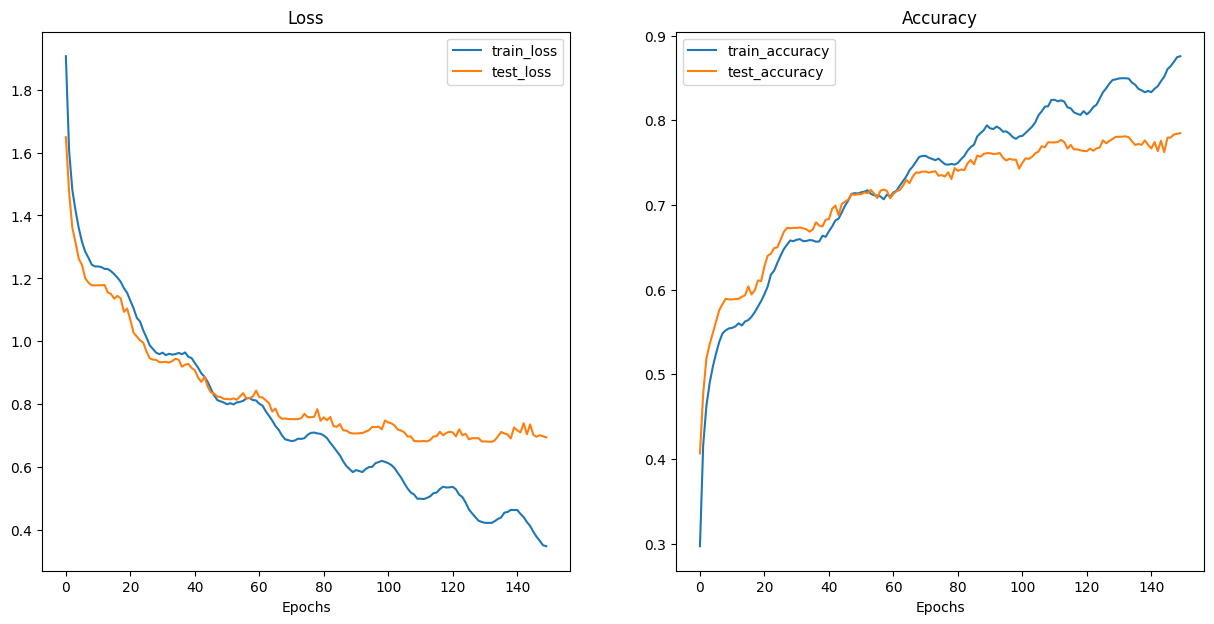

In [ ]:
plot_loss_curves(results)
plt.savefig("plots_150.png")

In [ ]:
   # Save checkpoint.

print('Saving..')
state = {"model": vit.state_dict(),
      "optimizer": optimizer.state_dict(),
      "results":results}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/'+'vit_150'+'-{}-ckpt.t7'.format(args.patch_size))


Saving..


In [ ]:
# Load checkpoint.
#print('==> Resuming from checkpoint..')
#assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#checkpoint = torch.load('./checkpoint/{}-ckpt.t7'.format("vit-4"))
#vit.load_state_dict(checkpoint['model'])
#best_acc = checkpoint['acc']
#start_epoch = checkpoint['epoch']